<a href="https://colab.research.google.com/github/aditeyabaral/kepler-exoplanet-analysis/blob/master/src/Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [18]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Loading Dataframe

In [2]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Selecting Columns for Prediction

In [3]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [4]:
print(len(TO_USE))
df[TO_USE].head()

19


,koi_insol,koi_depth,koi_fpflag_nt,koi_fpflag_ec,koi_duration,koi_srad,koi_prad,koi_fpflag_ss,koi_teq,koi_impact,koi_slogg,koi_fpflag_co,koi_kepmag,koi_period,dec,koi_model_snr,koi_steff,koi_time0bk,ra
0,93.59,615.8,0,0,2.95750,0.927,2.26,0,793.0,0.146,4.467,0,15.347,9.488036,48.141651,35.8,5455.0,170.538750,291.93423
1,9.11,874.8,0,0,4.50700,0.927,2.83,0,443.0,0.586,4.467,0,15.347,54.418383,48.141651,25.8,5455.0,162.513840,291.93423
2,39.30,10829.0,0,0,1.78220,0.868,14.60,1,638.0,0.969,4.544,0,15.436,19.899140,48.134129,76.3,5853.0,175.850252,297.00482
3,891.96,8079.2,0,0,2.40641,0.791,33.46,1,1395.0,1.276,4.564,0,15.597,1.736952,48.285210,505.6,5805.0,170.307565,285.53461
4,926.16,603.3,0,0,1.65450,1.046,2.75,0,1406.0,0.701,4.438,0,15.509,2.525592,48.226200,40.9,6031.0,171.595550,288.75488


# Extracting Dataframe Subset

We extract only those rows which are either positive or negative examples i.e. the `disposition value` is *not* `CANDIDATE`

In [5]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)
subset_df.head()

(6939, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Obtaining X and y

We also need to encode the categorical labels
```
CONFIRMED - 1
FALSE POSITIVE - 0
```

In [6]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [7]:
subset_df["koi_disposition"].value_counts()

FALSE POSITIVE    4647
CONFIRMED         2292
Name: koi_disposition, dtype: int64

# PCA Visualisation

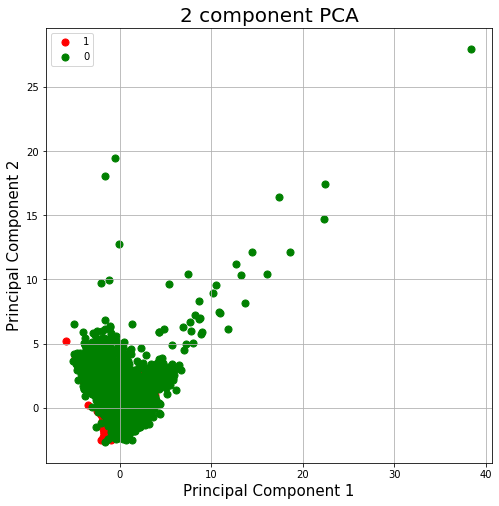

In [8]:
x = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["TARGET"] = y
finalDf = principalDf
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
# print(finalDf)

colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['TARGET'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

# Splitting into Train and Test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4649, 19), (2290, 19), (4649,), (2290,))

# Defining Evaluation Metric 

Since the dataset is imbalanced, we cannot use accuracy, hence we opt for either of the following -
* Confusion Matrix
* F1 Score
* Cohen Kappa Score
* Balanced Accuracy Score

In [11]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

# To-Do

### Stuff

* Feature Scaling
* Cross Validation
* Hyperparameter Tuning
* Feature Selection

### Algorithms
* XGBoost
* AdaBoost
* DBSCAN

# Decision Tree

In [12]:
# baseline model
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [13]:
performance(y_test, pred)

F1 Score: 0.952965235173824
Kappa Score: 0.9308004999566436
Accuracy Score: 0.9645681201387724
Confusion Matrix:
[[1522   32]
 [  37  699]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1554
           1       0.96      0.95      0.95       736

    accuracy                           0.97      2290
   macro avg       0.97      0.96      0.97      2290
weighted avg       0.97      0.97      0.97      2290



In [14]:
#tree.plot_tree(classifier, filled=True)
dot_tree = tree.export_graphviz(
    classifier,
    feature_names=subset_df[TO_USE].columns,  
    class_names=np.unique(subset_df["koi_disposition"].values),  
    filled=True, rounded=True,  
    special_characters=True
)
graph = graphviz.Source(dot_tree) 
graph.render("Decision Tree")
#graph

'Decision Tree.pdf'

In [15]:
"""text_graph = tree.export_text(
    classifier,
    feature_names=subset_df[TO_USE].columns.tolist()
)
print(text_graph)"""

'text_graph = tree.export_text(\n    classifier,\n    feature_names=subset_df[TO_USE].columns.tolist()\n)\nprint(text_graph)'

## Hyperparameter Tuning for Decision Tree

In [ ]:
parameters = {
    #"criterion":["gini", "entropy"],
    "splitter":["best", "random"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    "min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    "min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    "min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    "min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    "class_weight":[None, "balanced"],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    "ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
"""classifier = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)"""

# Random Forest

In [20]:
# baseline model
classifier = RandomForestClassifier(random_state=0, n_jobs=-1, verbose=1)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [21]:
performance(y_test, pred)

F1 Score: 0.9750692520775623
Kappa Score: 0.9635959628788334
Accuracy Score: 0.9769738682782161
Confusion Matrix:
[[1550    4]
 [  32  704]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1554
           1       0.99      0.96      0.98       736

    accuracy                           0.98      2290
   macro avg       0.99      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



## Hyperparameter Tuning for Random  Forest

In [29]:
parameters = {
    "n_estimators":np.arange(100,500,20),
    #"criterion":["gini", "entropy"],
    #"max_depth":[None] + np.linspace(1, 32, 32, endpoint=True).tolist(),
    #"min_samples_split":np.linspace(0, 1, 11, endpoint=True),
    #"min_samples_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    #"max_features":[None] + list(range(1,X_train.shape[1])),
    #"min_weight_fraction_leaf":np.linspace(0, 0.5, 6, endpoint=True),
    "random_state":[0],
    #"oob_score":[True, False],
    #"min_impurity_decrease":np.linspace(0, 1, 10, endpoint=True),
    #"class_weight":[None, "balanced", "balanced_subsample"],
    #"warm_start":[True, False],
    #"max_leaf_nodes":[None] + np.linspace(1, 25, 25, endpoint=True).tolist(),
    #"ccp_alpha":np.linspace(0, 10, 11, endpoint=True)
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
classifier = GridSearchCV(
    RandomForestClassifier(),
    param_grid=parameters,
    scoring=scores,
    refit=False,
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)